In [ ]:
! pip install spektral

In [31]:
from tensorflow.keras import backend as K
import tensorflow as tf


In [32]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.random import set_seed

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GATConv
from spektral.transforms import LayerPreprocess



Run this, needed for data generation. Takes max 2-3 mins.

In [33]:
import numpy as np
import random
import scipy.sparse as sp
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score as acc


def high_dim_gaussian(mu, sigma):
    if mu.ndim > 1:
        d = len(mu)
        res = np.zeros(d)
        for i in range(d):
            res[i] = np.random.normal(mu[i], sigma[i])
    else:
        d = 1
        res = np.zeros(d)
        res = np.random.normal(mu, sigma)
    return res


def generate_uniform_theta(Y, c):
    theta = np.zeros(len(Y), dtype='float')
    for i in range(c):
        idx = np.where(Y == i)
        sample = np.random.uniform(low=0, high=1, size=len(idx[0]))
        sample_sum = np.sum(sample)
        for j in range(len(idx[0])):
            theta[idx[0][j]] = sample[j] * len(idx[0]) / sample_sum
    return theta


def generate_theta_dirichlet(Y, c):
    theta = np.zeros(len(Y), dtype='float')
    for i in range(c):
        idx = np.where(Y == i)
        temp = np.random.uniform(low=0, high=1, size=len(idx[0]))
        sample = np.random.dirichlet(temp, 1)
        sample_sum = np.sum(sample)
        for j in range(len(idx[0])):
            theta[idx[0][j]] = sample[0][j] * len(idx[0]) / sample_sum
    return theta
    
def SBM(sizes, probs, mus, sigmas, noise,
        radius, feats_type='gaussian', selfloops=True):
    # -----------------------------------------------
    #     step1: get c,d,n
    # -----------------------------------------------
    c = len(sizes)
    if mus.ndim > 1:
        d = mus.shape[1]
    else:
        d = 1
    n = sizes.sum()
    all_node_ids = [ids for ids in range(0, n)]
    # -----------------------------------------------
    #     step2: generate Y with sizes
    # -----------------------------------------------
    Y = np.zeros(n, dtype='int')
    for i in range(c):
        class_i_ids = random.sample(all_node_ids, sizes[i])
        Y[class_i_ids] = i
        for item in class_i_ids:
            all_node_ids.remove(item)
    # -----------------------------------------------
    #     step3: generate A with Y and probs
    # -----------------------------------------------
    if selfloops:
        A = np.diag(np.ones(n, dtype='int'))
    else:
        A = np.zeros((n, n), dtype='int')
    for i in range(n):
        for j in range(i + 1, n):
            prob_ = probs[Y[i]][Y[j]]
            rand_ = random.random()
            if rand_ <= prob_:
                A[i][j] = 1
                A[j][i] = 1
    # -----------------------------------------------
    #     step4: generate X with Y and mus, sigmas
    # -----------------------------------------------
    X = np.zeros((n, d), dtype='float')
    for i in range(n):
        mu = mus[Y[i]]
        sigma = sigmas[Y[i]]
        X[i] = high_dim_gaussian(mu, sigma)

    return A, X, Y


def generate(p, q, idx):
    A, X, Y = \
        SBM(sizes=np.array([100, 100]),
        probs=np.array([[p, q], [q, p]]),
        mus=np.array([[-0.5]*20, [0.5]*20]),
        sigmas=np.array([[2]*20, [2]*20]),
        noise=[],
        radius=[],
        selfloops=False)
        
    return A, X, Y
        
        
def calculate(A, X, Y):

    A = sp.coo_matrix(A)
    A = A + A.T.multiply(A.T > A) - A.multiply(A.T > A)
    rowsum = np.array(A.sum(1)).clip(min=1)
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    A = A.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

    low = 0.5 * sp.eye(A.shape[0]) + A
    high = 0.5 * sp.eye(A.shape[0]) - A
    low = low.todense()
    high = high.todense()

    low_signal = np.dot(np.dot(low, low), X)
    high_signal = np.dot(np.dot(high, high), X)

    low_MLP = MLPClassifier(hidden_layer_sizes=(16), activation='relu', max_iter=2000)
    low_MLP.fit(low_signal[:100, :], Y[:100])
    low_pred = low_MLP.predict(low_signal[100:, :])

    high_MLP = MLPClassifier(hidden_layer_sizes=(16), activation='relu', max_iter=2000)
    high_MLP.fit(high_signal[:100, :], Y[:100])
    high_pred = high_MLP.predict(high_signal[100:, :])

    return acc(Y[100:], low_pred), acc(Y[100:], high_pred)


low_record = []
high_record = []


for i in range(1, 11):
    q = i * 0.01
    p = 0.05
    low_rec = []
    high_rec = []
    mlp_rec = []
    print(i, p, q)

    for j in range(10):
        A, X, Y = generate(p, q, 0)
        low, high, = calculate(A, X, Y)
        low_rec.append(low)
        high_rec.append(high)
    low_record.append([np.max(low_rec), np.min(low_rec), np.mean(low_rec)])
    high_record.append([np.max(high_rec), np.min(high_rec), np.mean(high_rec)])

print(low_record)
print(high_record)

1 0.05 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

2 0.05 0.02


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

3 0.05 0.03


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

4 0.05 0.04


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

5 0.05 0.05


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

6 0.05 0.06


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

7 0.05 0.07


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

8 0.05 0.08


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

9 0.05 0.09


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

10 0.05 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

[[0.98, 0.93, 0.9510000000000002], [0.94, 0.86, 0.8949999999999999], [0.86, 0.74, 0.795], [0.82, 0.66, 0.749], [0.7, 0.56, 0.6439999999999999], [0.66, 0.51, 0.597], [0.61, 0.41, 0.525], [0.56, 0.35, 0.45999999999999996], [0.62, 0.39, 0.4739999999999999], [0.48, 0.35, 0.417]]
[[0.71, 0.55, 0.614], [0.62, 0.53, 0.578], [0.62, 0.41, 0.5389999999999999], [0.61, 0.48, 0.567], [0.77, 0.52, 0.6679999999999999], [0.77, 0.62, 0.7050000000000001], [0.84, 0.71, 0.78], [0.93, 0.79, 0.853], [0.93, 0.85, 0.885], [0.98, 0.88, 0.923]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [34]:
from spektral.transforms.adj_to_sp_tensor import AdjToSpTensor

Store all 10 datasets in list "L"

In [35]:
L = []
for i in range(1, 11):
    q = i * 0.01
    p = 0.05
    A,X,Y = generate(p, q,0)
    L.append([p,q,A,X,Y])

In [36]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [37]:
import spektral.data.graph as gg
from scipy import sparse

Data preprocess: pass one of the dataset in "L" then format/preprocess data.

In [38]:
import random
import itertools
import math
from sklearn.model_selection import train_test_split

class DictionaryLookupDataset(object):
    def __init__(self, L):
        super().__init__()
        self.L = L
        
    def generate_data(self):
      indices = np.argwhere(self.L[2]==1)
      edge_index = sparse.csr_matrix((np.ones(len(indices.T[0])),(indices.T[0],indices.T[1])),shape=(200,200))
      nodes = self.L[3]      
      C = np.zeros((len(self.L[-1]),2))
      for i,j in enumerate(self.L[-1]):
        if j==0:
          C[i] = np.array([1,0])
        else:
          C[i] = np.array([0,1]) 
      LL_t=[]
      LL_v=[]
      pool0 = np.argwhere(self.L[-1]==0)
      pool1 = np.argwhere(self.L[-1]==1)
      np.random.shuffle(pool0)
      np.random.shuffle(pool1)
      tr = np.concatenate([pool0[0:50],pool1[0:50]])
      va = np.concatenate([pool0[50:],pool1[50:]])
      np.random.shuffle(tr)
      np.random.shuffle(va)
      C_tr = C[tr.flatten()] 
      C_va = C[va.flatten()] 
      LL_t.append(gg.Graph(x=nodes, a=edge_index, y=C_tr))
      LL_v.append(gg.Graph(x=nodes, a=edge_index, y=C_va))
      return LL_t,LL_v,tr.flatten(),va.flatten()


In [39]:
from spektral.data import Dataset

pass list and return dataset object.

In [40]:
class MyDataset(Dataset):

    def __init__(self, list_g, **kwargs):
        self.list_g = list_g

        super().__init__(**kwargs)
    
    def read(self):
      return self.list_g

In [41]:
from spektral.utils.convolution import degree_power,add_self_loops, normalized_adjacency
from spektral.transforms import gcn_filter

MODEL

In [42]:
from tensorflow.keras import constraints, initializers, regularizers

from spektral.layers import ops
from spektral.layers.convolutional.conv import Conv
from spektral.layers.ops import modes


class FAGCN(Conv):
    def __init__(
        self,
        channels,
        eps=0.3,
        L=5,
        out=2,
        deg=None,
        tr=None,
        freq = "FAGCN",
        dropout_rate=0.5,
        add_self_loops=False,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        **kwargs
    ):
        super().__init__(
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs
        )
        self.channels = channels
        self.eps = eps
        self.L = L
        self.deg = deg
        self.out = out
        self.tr = tr
        self.freq = freq
        self.dropout_rate = dropout_rate
        self.add_self_loops = add_self_loops
        
      
        self.output_dim = out

    def build(self, input_shape):

        input_dim = input_shape[0][-1]

        self.kernel1 = self.add_weight(
            name="kernel1",
            shape=[input_dim, self.channels],
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )

        self.kernel3 = self.add_weight(
            name="kernel3",
            shape=[self.channels,self.out ],
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )
        if self.freq == "FAGCN" or self.freq =="high freq high proportion" or self.freq =="low freq high proportion":
          self.kernel2 = self.add_weight(
              name="kernel2",
              shape=[self.channels, self.channels],
              initializer=self.kernel_initializer,
              regularizer=self.kernel_regularizer,
              constraint=self.kernel_constraint,
          )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=[self.output_dim],
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name="bias",
            )

        self.dropout = Dropout(self.dropout_rate, dtype=self.dtype)
        self.built = True

    def call(self, inputs, mask=None):
        x, a = inputs
  
       
        output = self._call_single(x, a)
        


        if self.use_bias:
            output += self.bias
        if mask is not None:
            output *= mask[0]
        output = self.activation(output)

        return output

    def _call_single(self, x, a):
        
        
        indices = a.indices
     

        N = tf.shape(x, out_type=indices.dtype)[-2]
        
        if self.add_self_loops:
            indices = ops.add_self_loops_indices(indices, N)
       
        targets, sources = indices[:, 1], indices[:, 0]

        x = K.dot(x, self.kernel1)

        x = tf.reshape(x, (-1, self.channels))
        raw = tf.keras.layers.ReLU()(x)
        raw = self.dropout(raw,training=self.tr)
        h = raw

        indexes = tf.concat([tf.expand_dims(targets, axis=1),tf.expand_dims(sources, axis=1)],1)  
        div = tf.gather_nd(indices=indexes,params=self.deg)
        div = div[...,None]

        for layers in range(0,self.L):
          if self.freq == "FAGCN":
            gh = K.dot(h, self.kernel2)
            theta1 = tf.gather(gh, targets)
            theta2 = tf.gather(gh, sources)
            alpha = tf.math.tanh(theta1+theta2)
            alpha = alpha*div 
 
          if self.freq == "high freq high proportion":
            gh = K.dot(h, self.kernel2)
            theta1 = tf.gather(gh, targets)
            theta2 = tf.gather(gh, sources)
            alpha = tf.math.tanh(theta1+theta2)
            alpha = -1 * tf.math.abs(alpha) 
            alpha = alpha*div 

          if self.freq == "low freq high proportion":
            gh = K.dot(h, self.kernel2)
            theta1 = tf.gather(gh, targets)
            theta2 = tf.gather(gh, sources)
            alpha = tf.math.tanh(theta1+theta2)
            alpha = 1 * tf.math.abs(alpha) 
            alpha = alpha*div 

          if self.freq == "pure high freq":
            alpha = -1*tf.math.abs(div) 

          if self.freq == "pure low freq":
            alpha = tf.math.abs(div) 

            
          alpha = self.dropout(alpha,training=self.tr)


          sums = tf.math.multiply(alpha, tf.gather(h, sources)) 

          sums = tf.math.unsorted_segment_sum(sums, targets,N) 

          h = self.eps*raw +sums

        output = K.dot(h, self.kernel3)

        
        return output


 

    @property
    def config(self):
        return {
            "channels": self.channels,
            "attn_heads": self.attn_heads,
            "concat_heads": self.concat_heads,
            "dropout_rate": self.dropout_rate,
            "return_attn_coef": self.return_attn_coef,
            "attn_kernel_initializer": initializers.serialize(
                self.attn_kernel_initializer
            ),
            "attn_kernel_regularizer": regularizers.serialize(
                self.attn_kernel_regularizer
            ),
            "attn_kernel_constraint": constraints.serialize(
                self.attn_kernel_constraint
            ),
        }

In [43]:
N = 200#14  # Number of nodes in the graph
F = 20  # Original size of node features
n_out = 2#7  # Number of classes


In [44]:
# Parameters
channels = 128  
dropout = 0.2  
learning_rate = 0.01
epochs = 20000  



x_in = Input(shape=(F))
a_in = Input((N), sparse=True)




In [45]:
from tensorflow import keras

loss_fn =  tf.keras.losses.BinaryCrossentropy(from_logits=False)


return training model

In [46]:
def model_tr_func(frequency,channels,dropout):
  gc_1 = FAGCN(
    channels,
    eps=0.3,
    L=1,
    deg = final,
    tr=True,
    freq = frequency,
    dropout_rate=dropout,
    activation="softmax",
)([x_in, a_in])
  model = Model(inputs=[x_in, a_in], outputs=gc_1)
  optimizer = Adam(learning_rate=learning_rate)
  return model,optimizer


return testing model

In [47]:
def model_test_func(frequency,channels,dropout):
  gc_1 = FAGCN(
      channels,
      eps=0.3,
      L=1,
      deg = final,
      tr=None,
      freq = frequency,
      dropout_rate=dropout,
      activation="softmax",
  )([x_in, a_in])
  model_test = Model(inputs=[x_in, a_in], outputs=gc_1)
  return model_test


TRAIN

In [48]:
def trainer(model,model_test,optimizer,loader_tr,loader_test):
  epochs = 300
  train_acc=0
  max_test_acc=0
  min_loss = 1000


  for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))

      for step, g in enumerate(train):
          inputs, target = loader_tr.__next__()
          with tf.GradientTape() as tape:
              logits = model(inputs, training=True)  
              logits = tf.gather(logits,LL[2])
              loss_value = loss_fn(target, logits)
              train_acc = sum(tf.argmax(logits,1).numpy()==tf.argmax(target,1).numpy())/len(target)
              
          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))

          inputs, target = loader_test.__next__()
          model_test.set_weights(model.get_weights())
          test_logits = model_test(inputs, training=False)
          test_logits = tf.gather(test_logits,LL[3])
          acc_test = sum(tf.argmax(test_logits,1).numpy()==tf.argmax(target,1).numpy())/len(target)
          
          if min_loss>loss_value:
            min_loss = loss_value
            max_test_acc = acc_test

          print(
              "Training loss (for one batch) at step %d: %.4f"
              % (step, float(loss_value))
          )
          
          print(
              "train-Accuracy (for one batch) at step %d: %.4f"
              % (step, float(train_acc))
          )
      
          print(
              "test-Accuracy (for one batch) at step %d: %.4f"
              % (step, float(acc_test))
          )
  
          print("Seen so far: %s samples" % ((step + 1)))
  return max_test_acc

Not interested in hyper-paramter tuning?<br>
Run the cell below.<br>
Change frequency to preferred frequency.<br>
Not interested in q from 0.01 to 0.1?<br>
Change range to (i,i+1) if interested in i*0.01.

In [49]:
LH=[]
frequency = "low freq high proportion"
for id in range(0,10):
  dictionary = DictionaryLookupDataset(L[id])
  LL = dictionary.generate_data()
  train = MyDataset(LL[0])
  test = MyDataset(LL[1])
  ad = np.copy(L[id][2])
  final = normalized_adjacency(ad)
  final=final.astype('float32')
  final = tf.convert_to_tensor(final)
  loader_tr = SingleLoader(train)
  loader_test = SingleLoader(test)

  model,optimizer = model_tr_func(frequency, channels, dropout)
  model_test = model_test_func(frequency, channels, dropout)
  max_test_acc = trainer(model, model_test, optimizer, loader_tr, loader_test)
  LH.append(max_test_acc)

Streaming output truncated to the last 5000 lines.
test-Accuracy (for one batch) at step 0: 0.6200
Seen so far: 1 samples

Start of epoch 67
Training loss (for one batch) at step 0: 0.0285
train-Accuracy (for one batch) at step 0: 0.9900
test-Accuracy (for one batch) at step 0: 0.6400
Seen so far: 1 samples

Start of epoch 68
Training loss (for one batch) at step 0: 0.0150
train-Accuracy (for one batch) at step 0: 1.0000
test-Accuracy (for one batch) at step 0: 0.6300
Seen so far: 1 samples

Start of epoch 69
Training loss (for one batch) at step 0: 0.0234
train-Accuracy (for one batch) at step 0: 1.0000
test-Accuracy (for one batch) at step 0: 0.6400
Seen so far: 1 samples

Start of epoch 70
Training loss (for one batch) at step 0: 0.0191
train-Accuracy (for one batch) at step 0: 1.0000
test-Accuracy (for one batch) at step 0: 0.6400
Seen so far: 1 samples

Start of epoch 71
Training loss (for one batch) at step 0: 0.0208
train-Accuracy (for one batch) at step 0: 1.0000
test-Accuracy 

In [50]:
import matplotlib.pyplot as plt


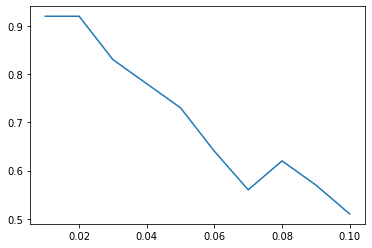

In [51]:
plt.plot(np.linspace(0.01,0.1,10),LH)

Hyper-paramter tuning

In [ ]:
hyper_para_dict = {}
names = ["FAGCN", "high freq high proportion", "low freq high proportion", "pure high freq", "pure low freq"]
grid = [(hidden, dropout) for hidden in [32, 64, 128] for dropout in [0.1, 0.2, 0.3, 0.4, 0.5]]

In [ ]:
for tup in grid:
  freq_dict = {}
  for name in names:
    result=[]
    for id in range(0,10):
      dictionary = DictionaryLookupDataset(L[id])
      LL = dictionary.generate_data()
      train = MyDataset(LL[0])
      test = MyDataset(LL[1])
      ad = np.copy(L[id][2])
      final = normalized_adjacency(ad)
      final=final.astype('float32')
      final = tf.convert_to_tensor(final)
      loader_tr = SingleLoader(train)
      loader_test = SingleLoader(test)

      model,optimizer = model_tr_func(name,tup[0],tup[1])
      model_test = model_test_func(name,tup[0],tup[1])
      max_test_acc = trainer(model, model_test, optimizer, loader_tr, loader_test)
      result.append(max_test_acc)
    freq_dict[name] = result
  hyper_para_dict[tup] = freq_dict


Streaming output truncated to the last 5000 lines.
test-Accuracy (for one batch) at step 0: 0.4400
Seen so far: 1 samples

Start of epoch 67
Training loss (for one batch) at step 0: 0.4978
train-Accuracy (for one batch) at step 0: 0.7800
test-Accuracy (for one batch) at step 0: 0.4600
Seen so far: 1 samples

Start of epoch 68
Training loss (for one batch) at step 0: 0.5548
train-Accuracy (for one batch) at step 0: 0.7200
test-Accuracy (for one batch) at step 0: 0.4700
Seen so far: 1 samples

Start of epoch 69
Training loss (for one batch) at step 0: 0.5199
train-Accuracy (for one batch) at step 0: 0.7600
test-Accuracy (for one batch) at step 0: 0.5000
Seen so far: 1 samples

Start of epoch 70
Training loss (for one batch) at step 0: 0.4957
train-Accuracy (for one batch) at step 0: 0.7300
test-Accuracy (for one batch) at step 0: 0.4900
Seen so far: 1 samples

Start of epoch 71
Training loss (for one batch) at step 0: 0.4741
train-Accuracy (for one batch) at step 0: 0.7600
test-Accuracy 

Load google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [53]:
%cd '/content/drive/My Drive/'

/content/drive/My Drive


In [ ]:
!ls

Only interested in loading and viewing results?<br>
Please proceed.

In [55]:
import matplotlib.pyplot as plt

In [56]:
import pickle

In [57]:
file_name = 'FAGCN-HYP.pkl'

# open_file = open(file_name, "wb")
# pickle.dump(hyper_para_dict, open_file)
# open_file.close()

open_file = open(file_name, "rb")
loaded_dict = pickle.load(open_file)
open_file.close()

In [58]:
len(loaded_dict)

15

In [60]:
names = ["FAGCN", "high freq high proportion", "low freq high proportion", "pure high freq", "pure low freq"]

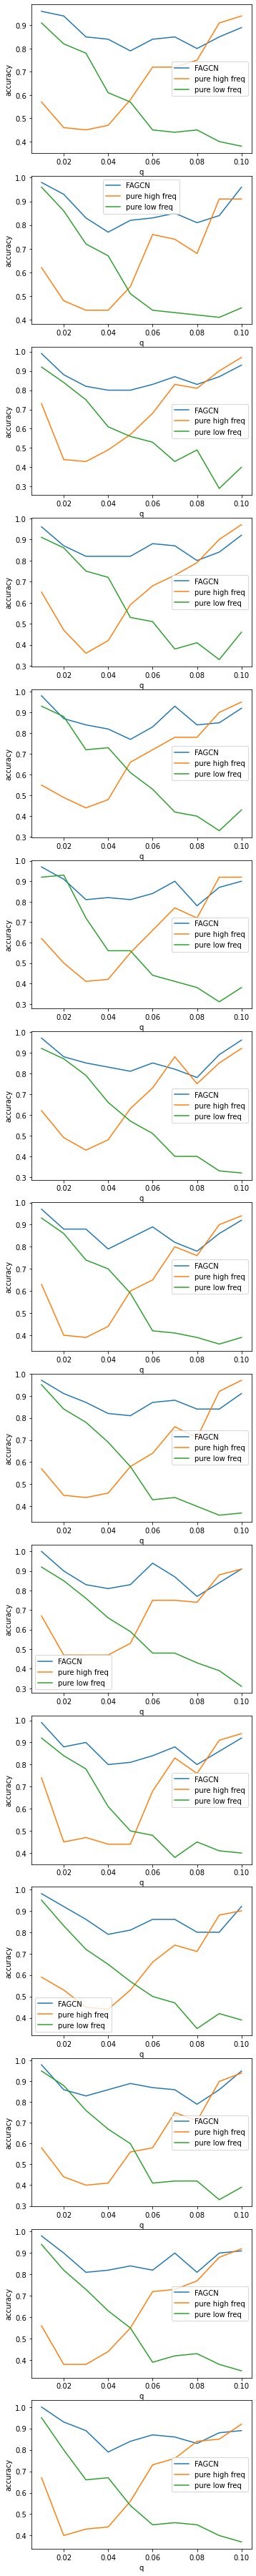

In [62]:
fig, axs = plt.subplots(15, 1,figsize=(5,50))
fig.tight_layout()
count = 0
for i in loaded_dict:
    for name in ["FAGCN", "pure high freq", "pure low freq"]:
      axs[count].plot(np.linspace(0.01,0.1,10),loaded_dict[i][name])
      axs[count].legend(["FAGCN", "pure high freq", "pure low freq"])
      axs[count].set(xlabel='q', ylabel='accuracy')
    count+=1

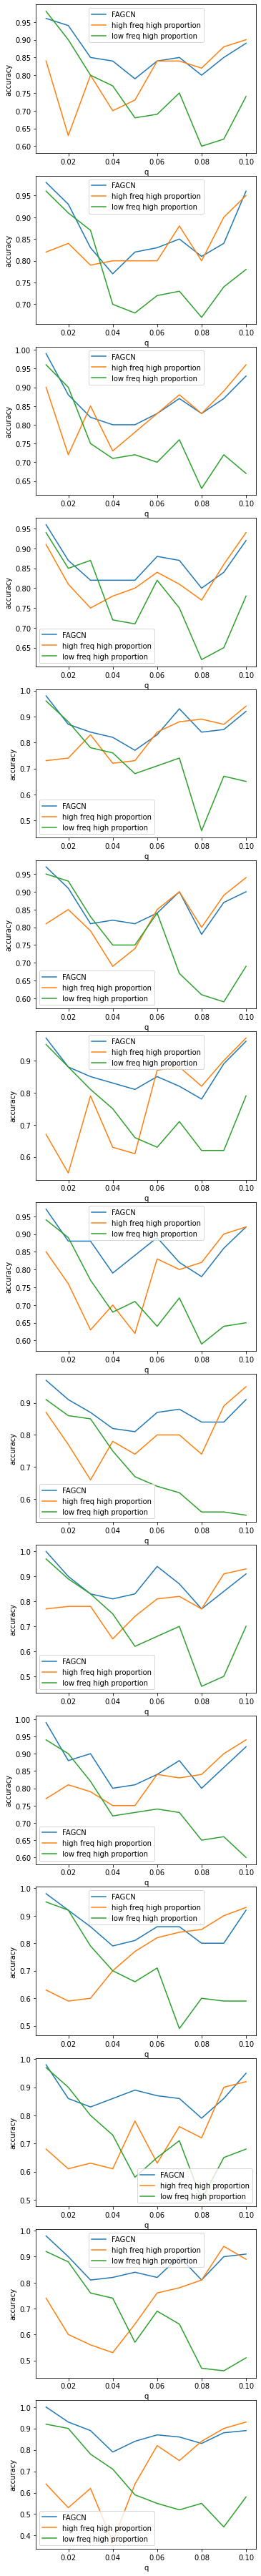

In [61]:
fig, axs = plt.subplots(15, 1,figsize=(5,50))
fig.tight_layout()
count = 0
for i in loaded_dict:
    for name in names[0:3]:
      axs[count].plot(np.linspace(0.01,0.1,10),loaded_dict[i][name])
      axs[count].legend(["FAGCN", "high freq high proportion", "low freq high proportion"])
      axs[count].set(xlabel='q', ylabel='accuracy')
    count+=1

 

In [63]:
loaded_dict[(128,0.3)]["pure low freq"]

[0.95, 0.88, 0.76, 0.67, 0.6, 0.41, 0.42, 0.42, 0.33, 0.39]

In [64]:
loaded_dict[(128,0.3)]["pure high freq"]

[0.58, 0.44, 0.4, 0.41, 0.56, 0.58, 0.75, 0.71, 0.9, 0.94]

In [65]:
loaded_dict[(128,0.3)]["FAGCN"]

[0.98, 0.86, 0.83, 0.86, 0.89, 0.87, 0.86, 0.79, 0.86, 0.95]